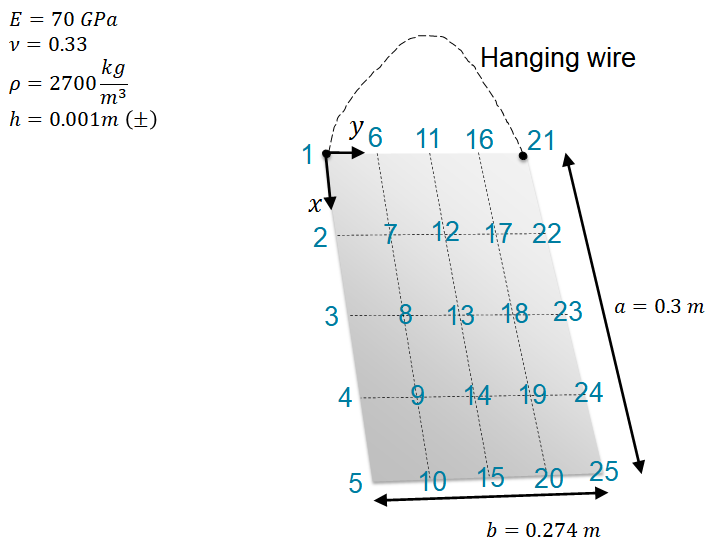

In [40]:
import sys
sys.path.append(r'../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi
from scipy.linalg import cholesky, eigh
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF

def mag2db(mag):
    return 20*np.log10(mag)


nx = 25
ny = 25

a = 0.300 # [m]
b = 0.274 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.001 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

acc_pos05 = np.where(np.isclose(x, a) & np.isclose(y, 0))[0][0]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

plate = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True)

N = DOF*nx*ny
K = np.zeros((N, N))
M = np.zeros((N, N))
quads = []

for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.rho = rho
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = h
    quad.ABDE = plate.ABDE
    update_K(quad, nid_pos, ncoords, K)
    update_M(quad, nid_pos, ncoords, M)
    quads.append(quad)

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True


m_acc = 0.001
M[acc_pos05*DOF+0, acc_pos05*DOF+0] += m_acc
M[acc_pos05*DOF+1, acc_pos05*DOF+1] += m_acc
M[acc_pos05*DOF+2, acc_pos05*DOF+2] += m_acc

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]

L = cholesky(Muu, lower=True)
Linv = np.linalg.inv(L)
Ktilde = Linv @ Kuu @ Linv.T

rbmodes = 3
Nmodes = 35
gamma, V = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
print('all omegan', gamma[:10]**0.5)
V = V[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

P = V


zeta = 0.02

omegad = omegan*np.sqrt(1 - zeta**2)

print('omegan [Hz]', omegan/(2*pi))
print('omegad [Hz]', omegad/(2*pi))


all omegan [          nan           nan           nan  246.04729604  353.64044075
  470.50182265  620.33992781  668.93303571 1050.92673351 1181.99253222]
omegan [Hz] [ 39.1596434   56.28362422  74.88269081  98.73016591 106.46399923
 167.26018447 188.1199542  200.91745238 203.71947348 235.30706852
 268.51012711 310.08318678 328.16540819 334.32714371 369.09233294
 401.61177204 429.89118177 468.89652536 487.78560429 530.07471909
 563.89995053 597.0242746  655.55611744 671.58779321 694.27563442
 707.15943293 727.05484165 810.83901572 856.50849934 879.50644966
 914.45031015 924.76314009]
omegad [Hz] [ 39.15181069  56.27236637  74.86771277  98.7104179  106.4427043
 167.22672908 188.08232645 200.87726487 203.67872551 235.2600024
 268.45641972 310.02116394 328.09976855 334.2602716  369.01850709
 401.53144166 429.80519493 468.80273667 487.68803741 529.96869354
 563.78715926 596.9048578  655.42499311 671.45346221 694.13676541
 707.0179869  726.90941614 810.6768317  856.3371805  879.33053078
 914

C:\ProgramData\Anaconda3\envs\idp\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt


omega1 39.159643399700805


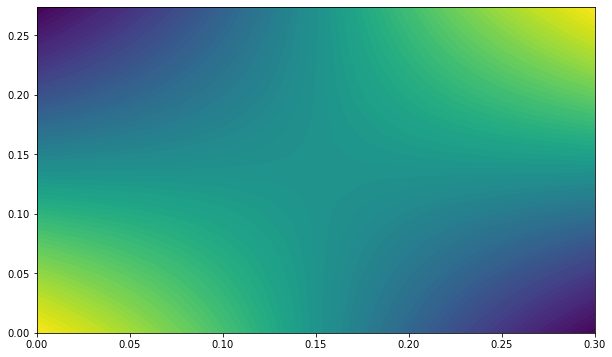

In [41]:
mode = 0
Uu = (Linv.T @ V[:, mode])
U = np.zeros(K.shape[0])
U[bu] = Uu
plt.contourf(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=100)
print('omega1', omegan[mode]/(2*pi))


Hammer Impact Parameters
---

In [42]:
tmax = 1.953
Nsamples = 2**16

t = np.linspace(0, tmax, Nsamples)
dt = t[1] - t[0]
Nsamples = t.size
print('Nsamples', Nsamples)

ximpact = a/4
yimpact = 3*b/4

hammer = np.zeros_like(t)
impulse = 0.021871147552536902
ind = 10
step = t[ind]
hammer[:ind+1] = -impulse/step

print('force', impulse/step)


Nsamples 65536
force 73.39097055071714


Simulating Impact Hammer Test
---

In [43]:
# dynamic analysis

on = omegan[:, None]
od = omegad[:, None]

# convolution integral: general load as a sequence of impulse loads
def r_t(t, t1, t2, on, zeta, od, fmodaln):
    tn = (t1 + t2)/2
    dt = t2 - t1
    # damped function
    H = np.heaviside(t - tn, 1.)
    h = np.zeros((Nmodes-rbmodes, t.shape[0]))
    check = t >= tn
    h[:, check] = 1/od*np.exp(-zeta*on*(t[check] - tn))*np.sin(od*(t[check] - tn))*H[check]
    
    return fmodaln*dt*h

def rdotdot_t(t, t1, t2, on, zeta, od, fmodaln):
    tn = (t1 + t2)/2
    dt = t2 - t1
    # damped function
    H = np.heaviside(t - tn, 1.)
    h = np.zeros((Nmodes-rbmodes, t.shape[0]))
    check = t >= tn
    h[:, check] = (-od*np.sin(od*(t[check] - tn)) - 2*on*zeta*np.cos(od*(t[check] - tn)) 
     + on**2*zeta**2*np.sin(od*(t[check] - tn))/od)*np.exp(-on*zeta*(t[check] - tn))
    
    return fmodaln*dt*h


f = np.zeros(N)

responses = {}
u = np.zeros((N, len(t)))
acc = np.zeros((N, len(t)))

print('point of impact:', ximpact, yimpact)
force_pos = np.where(np.isclose(x, ximpact) & np.isclose(y, yimpact))[0][0]

f[:] = 0
f[DOF*force_pos+2] += hammer[0]

# calculating modal forces
fmodaln = (P.T @ Linv @ f[bu])[:, None]

# assuming only particular solution
r = r_t(t, 0, step, on, zeta, od, fmodaln)

# assuming only particular solution
rdotdot = rdotdot_t(t, 0, step, on, zeta, od, fmodaln)

# transforming from r-space to displacement and acceleration
u[bu] = Linv.T @ P @ r
acc[bu] = Linv.T @ P @ rdotdot

response_u = u[DOF*acc_pos05+2].copy()
response = acc[DOF*acc_pos05+2].copy()/9.81


point of impact: 0.075 0.20550000000000002


Checking signals in frequency domain
---

Text(0, 0.5, 'acceleration [g]')

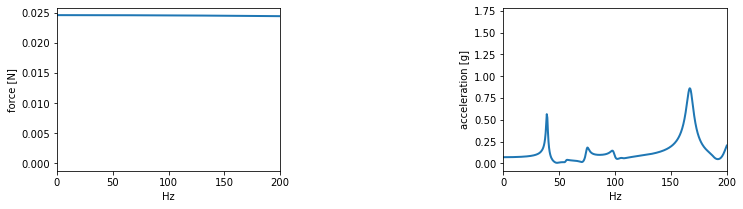

In [44]:
# Fast Fourier Transform to get the frequencies
freqs = np.fft.rfftfreq(Nsamples, dt)
xf = np.fft.rfft(hammer)/(Nsamples//2)
yf = np.fft.rfft(response)/(Nsamples//2)

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))
plt.subplots_adjust(wspace=1)
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 200)
axes[0].plot(freqs, np.abs(xf))
axes[0].set_xlabel('Hz')
axes[0].set_ylabel('force [N]')
axes[1].plot(freqs, np.abs(yf))
axes[1].set_xlabel('Hz')
axes[1].set_ylabel('acceleration [g]')

Frequency Response Function
---

(0.2, 30)

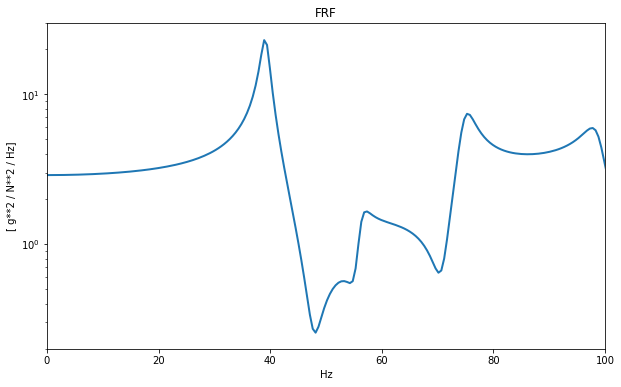

In [45]:
pxx = np.conj(xf)*xf 
pxy = np.conj(xf)*yf 
H = np.zeros_like(pxx)
check = ~np.isclose(pxx, 0+0j)
H[check] = pxy[check]/pxx[check]
plt.semilogy(freqs, np.abs(H))
plt.ylabel('[ g**2 / N**2 / Hz]')
plt.xlabel('Hz')
plt.title('FRF')
plt.xlim(0, 100)
plt.ylim(0.2, 30)



estimated amplitude 1.7012605794807392


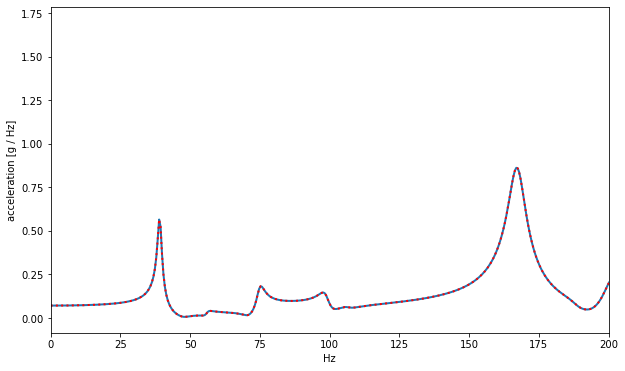

In [46]:
yf_est = H*xf
plt.plot(freqs, np.abs(yf_est))
plt.plot(freqs, np.abs(yf), 'r:')
plt.xlim(0, 200)
plt.xlabel('Hz')
plt.ylabel('acceleration [g / Hz]')
print('estimated amplitude', np.abs(yf_est).max())

original and estimated max acceleration
377.2504838311251 377.3276475592389

original and estimated RMS acceleration
14.994932229108159 14.994930372155574


Text(0, 0.5, 'acceleration [g]')

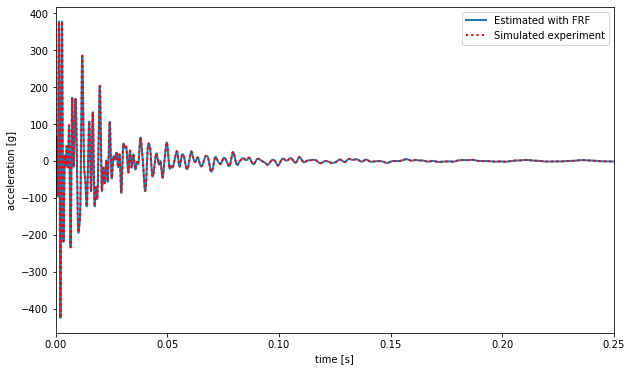

In [47]:
y_est = np.fft.irfft(yf_est*(Nsamples//2))
plt.plot(t, y_est, label='Estimated with FRF')
plt.plot(t, response, ':r', label='Simulated experiment')
plt.legend()
plt.xlim(0, 0.25)
print('original and estimated max acceleration')
print(response.max(), y_est.max())
print()
print('original and estimated RMS acceleration')
print((response**2).mean()**0.5, (y_est**2).mean()**0.5)
plt.xlabel('time [s]')
plt.ylabel('acceleration [g]')